In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [198]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)

In [4]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [5]:
%%R
physeq = subset_samples(physeq,sample_sums(physeq)>1)

In [9]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Trtmt,Month){
    physeq.pruned <- prune_samples((sample_data(physeq)$Month == Month) & ((sample_data(physeq)$Trtmt == Trtmt) | (sample_data(physeq)$Trtmt == "Q")),physeq)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"Q")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq)
    results$Month = Month
    results$Trtmt = Trtmt
    results = data.frame(results$Month,results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("Month","Trtmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }

In [10]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("F"),
                        Month = c(2, 2.5, 3))
variables

  Trtmt Month
1     F   2.0
2     F   2.5
3     F   3.0


In [241]:
%%R
variables<-variables[c(1,2,5,6,7,8,9,10,11),]
#Choosing only the rows for which we have data
variables

   Trtmt Month
1      Q   2.0
2      F   2.0
5      Q   2.5
6      F   2.5
7      K   2.5
8      H   2.5
9      Q   3.0
10     F   3.0
11     K   3.0


In [11]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [62]:
%%R
levels(DA$Trtmt)

[1] "F"


In [63]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

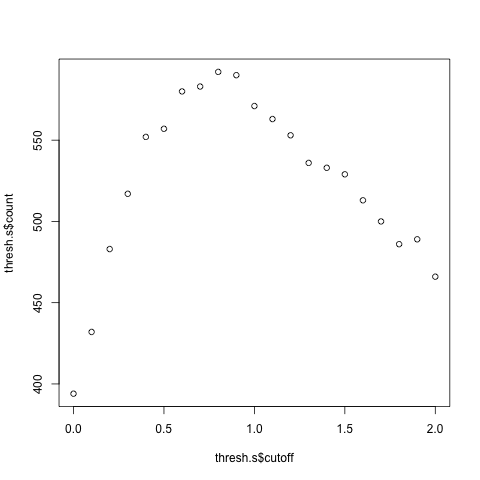

In [71]:
%%R
range = seq(0,2,0.1)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.3)

In [69]:
%%R
filter(DA,baseMean>=0.8) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../../SeqData/l2fcQF.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [70]:
%%R
l2fc<-read.csv("../../SeqData/l2fcQF.csv")
head(l2fc)

  Month Trtmt       OTU baseMean       l2FC       SE    pvalue  Kingdom
1     2 FALSE 65_942692 1.007420 -1.3453097 1.968268 0.4942915 Bacteria
2     2 FALSE  7_125682 1.811599  1.2966121 1.847851 0.4828746 Bacteria
3     2 FALSE 91_159495 2.902113 -1.5074850 1.909852 0.4299249 Bacteria
4     2 FALSE 93_461508 1.409079  0.8795533 2.121626 0.6784599 Bacteria
5     2 FALSE 91_296936 1.104884  0.5283883 2.247220 0.8141081 Bacteria
6     2 FALSE  6_342540 1.375742  3.2645624 2.443369 0.1815196 Bacteria
          Phylum              Class   Order Family Genus Species      padj
1 Proteobacteria Betaproteobacteria SC-I-84   <NA>  <NA>    <NA> 0.7285310
2 Proteobacteria Betaproteobacteria SC-I-84   <NA>  <NA>    <NA> 0.7192720
3 Proteobacteria Betaproteobacteria SC-I-84   <NA>  <NA>    <NA> 0.6735609
4 Proteobacteria Betaproteobacteria SC-I-84   <NA>  <NA>    <NA> 0.8492061
5 Proteobacteria Betaproteobacteria SC-I-84   <NA>  <NA>    <NA> 0.9201903
6 Proteobacteria Betaproteobacteria SC-I-84   

In [190]:
%%R
Trtmt = c("A","A","A","A","A","A","B","B","B","B","B","B")
Month = c(1,1,1,2,2,2,1,1,1,2,2,2)
baseMean = c(3,2,1,3,2,3,1,2,4,2,3,1)
h=data.frame(Trtmt,Month,baseMean)
h.relabund = dplyr::group_by(h, Trtmt, Month) %>%
                dplyr::mutate(relabund=baseMean/sum(baseMean))
h.relabund$relabund
# Testing to make sure I am calculating the relative abundances correctly (yes).

   Trtmt Month baseMean
1      A     1        3
2      A     1        2
3      A     1        1
4      A     2        3
5      A     2        2
6      A     2        3
7      B     1        1
8      B     1        2
9      B     1        4
10     B     2        2
11     B     2        3
12     B     2        1


In [74]:
%%R
d = l2fc
#d$relAbund = d$baseMean / sum(d$baseMean)

d.relabund = dplyr::group_by(d, Trtmt, Month) %>%
                dplyr::mutate(relabund=baseMean/sum(baseMean))
head(d.relabund$relabund)
#relabund <- summarise(counts, relabund = baseMean/sum(baseMean))
#head(arrange(games, desc(total)), 5)

[1] 5.534539e-05 9.952520e-05 1.594355e-04 7.741164e-05 6.069987e-05
[6] 7.558019e-05


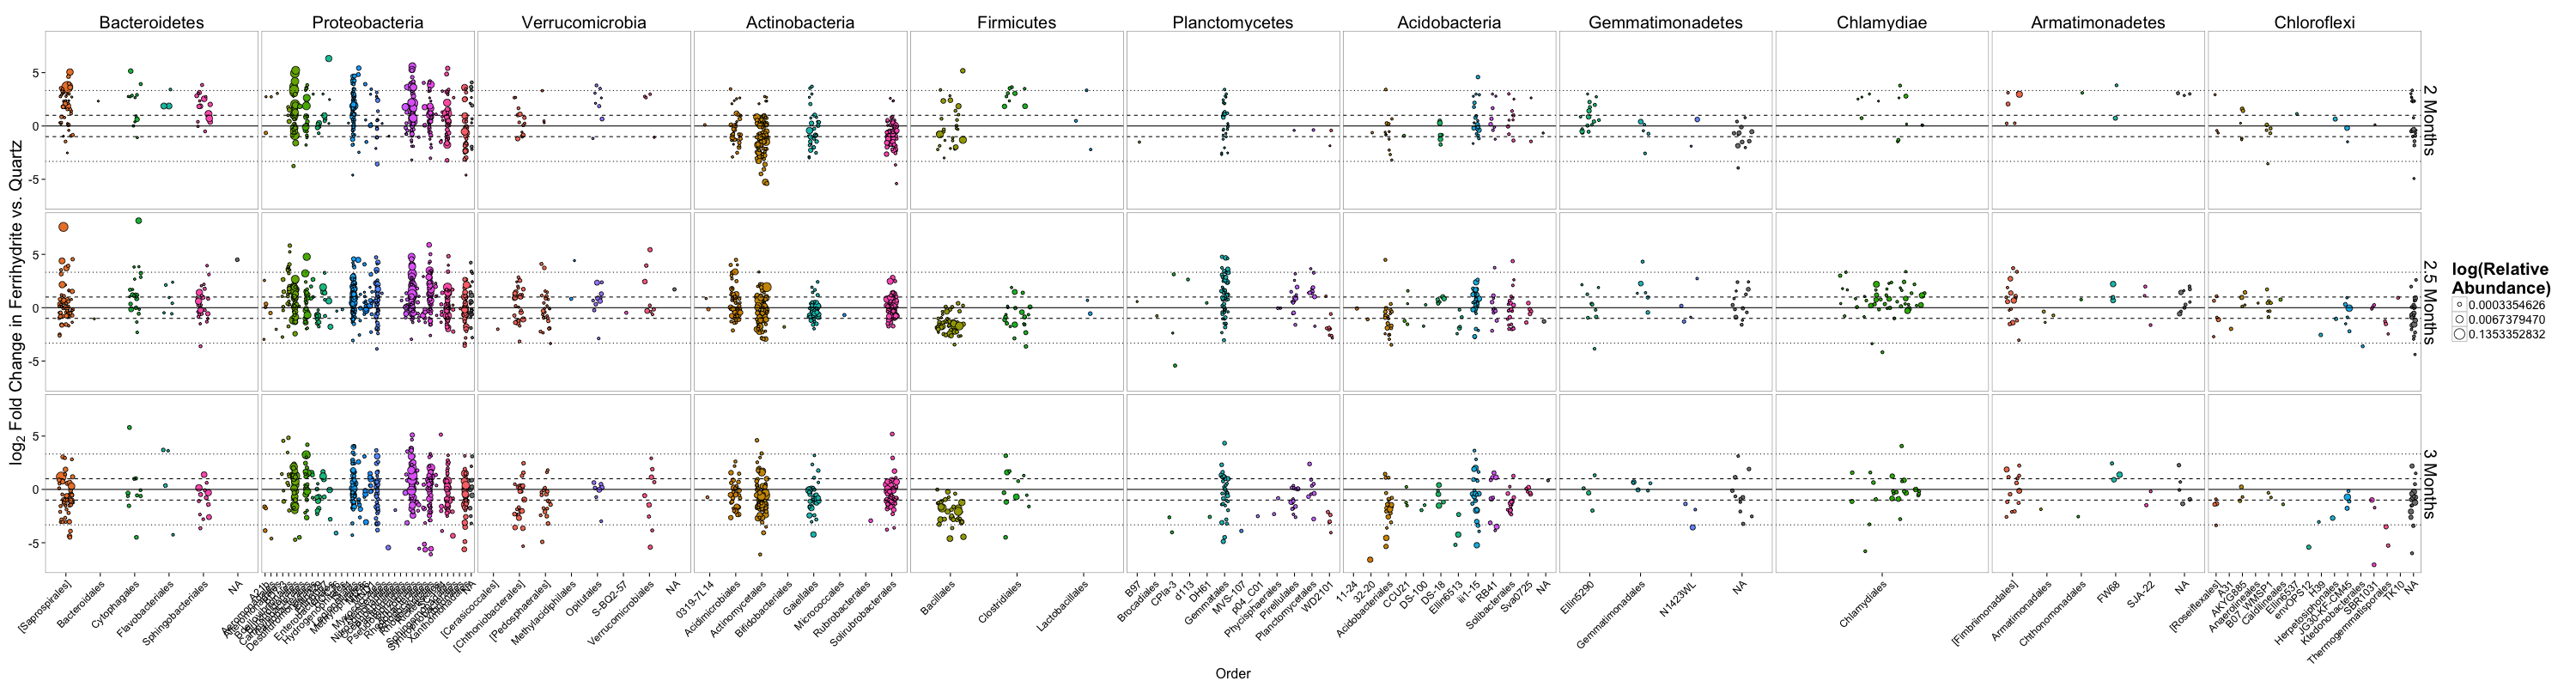

In [167]:
%%R -w 3000 -h 800
# setting the image sizes, then making the figure...

d = d.relabund

N=50

Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)    

    
d$MonthName = ifelse(d$Month==2,"2 Months",(ifelse(d$Month==2.5, "2.5 Months","3 Months")))
d$strip1 = paste(d$MonthName)
# Creates a "strip" column of d with Months

max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values

p = ggplot(d, aes(x = Order, y = l2FC, fill = Order, size = relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~strip1~Phylum, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Order")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change in Ferrihydrite vs. Quartz",sep="")))
# sets the label for the y axes.


#p = p + scale_color_continuous(trans="log")    
p = p + scale_fill_discrete(guide="none")
    
#colourCount = length(unique(d$Order))
#getPalette = colorRampPalette(brewer.pal(8, "Dark2"))
#p = p + scale_colour_manual(values=getPalette(colourCount))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [178]:
%%R
d = l2fc
d.Sapro <- d[d$Order=="[Saprospirales]",]
d.Sapro <- d.Sapro[complete.cases(d.Sapro$OTU),]
d.Sapro[d.Sapro$baseMean==max(d.Sapro$baseMean),]

    Month Trtmt    OTU baseMean     l2FC       SE pvalue  Kingdom        Phylum
456     2 FALSE 28_165 3569.346 3.659961 2.443117     NA Bacteria Bacteroidetes
            Class           Order           Family        Genus Species padj
456 [Saprospirae] [Saprospirales] Chitinophagaceae Chitinophaga    <NA>   NA


I want to know, of the high-log2fold change samples, what the relative breakdown of relative abundance by taxonomic group is.

We have the baseMean (mean of normalized counts), so we can use its relative abundance.

Then, for the actual plots, I want to plot it by Phylum (or Order, or whatever), facetted across months, so I need to sum the values of all the OTUs in each taxonomic group and make a new table with this.

In [312]:
%%R

d.high = l2fc %>%
# Take the l2fc data frame,
    dplyr::filter(l2FC>3)%>%
# Include only the 2.5 month samples and take the rows where
# log2fold change is higher than 3, and the adjusted pval is less than 0.05.
    dplyr::group_by(Month) %>%
# Then, treating each month separately,
    dplyr::mutate(relabund=baseMean/sum(baseMean)) %>%
# Create a new column called relabund, which is the mean normalized count, divided by the total
# (total of those we selected, not of the whole dataset). 
    dplyr::group_by(Genus, Month) %>%
# Then, using this data, still grouped by month, we further group it by phylum,
    dplyr::summarise(relabund=sum(relabund))
# And we tally up all the relative counts for each taxonomic group.

colnames(d.high) <- c("Tax","Month","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.high$Tax = factor(d.high$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the phyla by abundance
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order

d.high


Source: local data frame [75 x 3]

             Tax Month    relabund
1   Chitinophaga   2.0 0.538135088
2   Chitinophaga   2.5 0.313570618
3    Caulobacter   2.5 0.056926552
4    Caulobacter   3.0 0.512335280
5      Rhizobium   2.0 0.011607947
6      Rhizobium   2.5 0.199110907
7      Ralstonia   2.0 0.032325894
8  Agrobacterium   2.0 0.001067719
9  Agrobacterium   2.5 0.043181909
10 Agrobacterium   3.0 0.014804661
..           ...   ...         ...


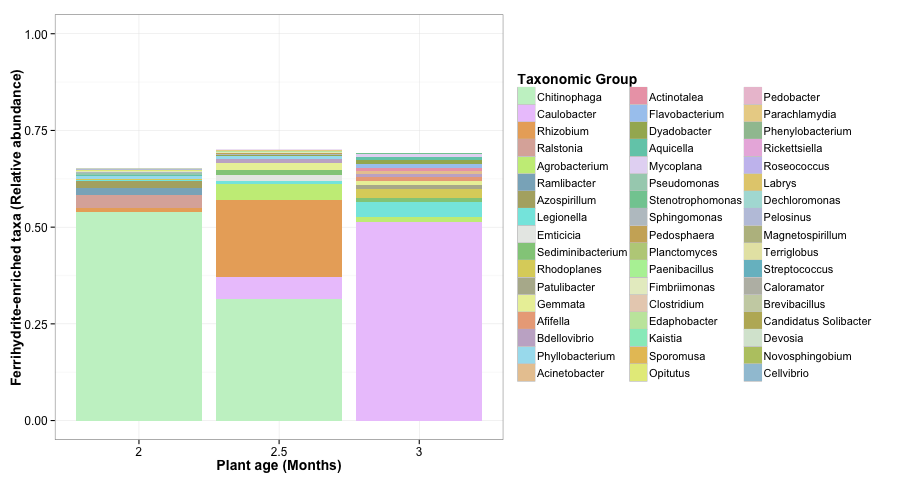

In [309]:
%%R -w 900

d.plot = d.high

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)
d.plot$Month <- as.factor(d.plot$Month)

p = ggplot(d.plot, aes(x=Month,y=relabund,fill = Tax))

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Taxonomic Group", ncol = 3))

p = p + xlab("Plant age (Months)") + ylab("Ferrihydrite-enriched taxa (Relative abundance)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11))
p = p + theme(legend.title=element_text(size=14))

p